In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from astropy.constants import c
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quadrature
import numba as nb

%matplotlib inline

/tmp/ipykernel_173862/1662233708.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate $C_l^{\Delta g}(r_1, r_2)$

In [2]:
sigma = 0.2 # Standard deviation of the fiducial dndz
z_mean = 1 # Central redshift of the fiducial dndz

# Set the range for the integrals over r. If this changes, the normalization of phi(r) will need to be changed too
z_min_int = 0.005
z_max_int = z_mean+sigma*5

# Now characterize the perturbations to the dndz
sigma_zshift = z_mean/5. # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = 0 #sigma/10. # Standard deviation of the variations in the width of the distribution
modulation_of_mean_of_draws = 0 # Consider also modulating the mean of these shifts across the sky

In [3]:
# The user input is in redshift units because this is more intuitive. However, we will define our dndzs to be
# Gaussian in comoving distance. So next, we convert to chi
chi_mean_fid = Planck18.comoving_distance(z_mean).value
chi_sigma_fid = Planck18.comoving_distance(z_mean + sigma).value - Planck18.comoving_distance(z_mean).value
chi_min_int = Planck18.comoving_distance(z_min_int).value
chi_max_int = Planck18.comoving_distance(z_max_int).value

sigma_chishift = Planck18.comoving_distance(z_mean + sigma_zshift).value - Planck18.comoving_distance(z_mean).value
sigma_chiwidth = Planck18.comoving_distance(z_mean + sigma_zwidth).value - Planck18.comoving_distance(z_mean).value

In [4]:
# Suppose the dndz changes across different healpixels
nside = 8 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r (r is comoviing distance throughout)
n_samples_of_chi = 2**8 # Choose a power of 2
chi_array = np.linspace(chi_min_int,chi_max_int,n_samples_of_chi) 

# Get the redshift corresponding to these values of chi in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_chi))
for i, chi in enumerate(chi_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, chi* u.Mpc) 

In [5]:
# Draw random values in each pixel for the shift of the central redshift of the dndz
chimean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_chishift, size=npix)
width_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_chiwidth, size=npix)

In [6]:
# In each pixel, calculate the perturbed dndz as a Gaussian in chi
dndz_perturbed = (1/((chi_sigma_fid+width_shifts_array[..., np.newaxis])*np.sqrt(2*np.pi))) * np.exp(-(chi_array - chi_mean_fid - chimean_shifts_array[..., np.newaxis])**2 /(2*(chi_sigma_fid+width_shifts_array[..., np.newaxis])**2))
# Take the fiducial dndz to be the monopole of the perturbed dndz
dndz_fid = np.mean(dndz_perturbed, axis=0)

# Convert dndz to selection function
phi_perturbed_array = (Planck18.H(z_array[0,:]) / c).value * dndz_perturbed
phi_fid_array = (Planck18.H(z_array[0,:]) / c).value * dndz_fid

# Normalize the selection function so that \int_{0}^{inf} dr phi(r) = 1
phi_norm, error = quadrature(interp1d(chi_array, phi_fid_array), chi_min_int, chi_max_int, tol=1e-20, maxiter=500)
phi_perturbed_array *= phi_norm**(-1)
phi_fid_array *= phi_norm**(-1)
dndz_fid_normed = dndz_fid / phi_norm
phi_fid = interp1d(chi_array, phi_fid_array, bounds_error=False, fill_value='extrapolate')
phi_pert = interp1d(chi_array, phi_perturbed_array, bounds_error=False, fill_value='extrapolate')

In [7]:
@nb.jit(nopython=True)
def integral_at_chi(chi, chi_max_int, phi_array, chi_s):
    min_idx = np.where(chi_s>=chi)[0][0]

    if phi_array.ndim==2:
        outs_at_chi = np.zeros(phi_array.shape[0], dtype=float)
        for j in range(phi_array.shape[0]):
            # Iterate over healpixels
            integrand = phi_array[j,:] * (chi_s - chi)/chi_s
            outs_at_chi[j] = np.trapz(integrand[min_idx:], chi_s[min_idx:])
    else:
        integrand = phi_array * (chi_s - chi)/chi_s
        outs_at_chi = np.trapz(integrand[min_idx:], chi_s[min_idx:])
    return outs_at_chi

@nb.jit(nopython=True)
def lens_efficiency_kernel(chis, chi_max_int, phi_array):
    output = np.zeros_like(phi_array)
    if phi_array.ndim==1:
        for i, chi in enumerate(chis):
            output[i] = integral_at_chi(chi, chi_max_int, phi_array, chis)
    else:
        for i, chi in enumerate(chis):
            output[:, i] = integral_at_chi(chi, chi_max_int, phi_array, chis)
    return output

In [8]:
# Dummy run to pre-compile with numba
lens_efficiency_kernel(chi_array, chi_max_int, np.zeros(256))

# Now in earnest
g_fid = 3/2. * Planck18.Om0 * Planck18.H0.value**2 / c.value**2 * chi_array * (1+z_array[0,:]) * lens_efficiency_kernel(chi_array, chi_max_int, phi_fid_array)
g_pert = 3/2. * Planck18.Om0 * Planck18.H0.value**2 / c.value**2 * chi_array * (1+z_array[0,:]) * lens_efficiency_kernel(chi_array, chi_max_int, phi_perturbed_array)

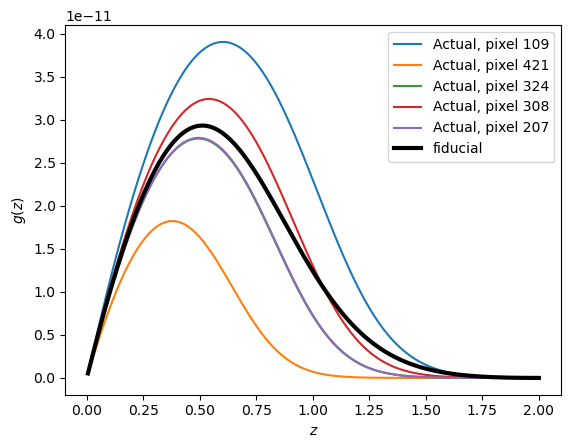

In [9]:
# Extract the perturbation
delta_g_maps = g_pert - g_fid

# Plot some typical realizations
for pixel_id in np.random.randint(0,npix,5):
    plt.plot(z_array[0,:], g_pert[pixel_id,:], label='Actual, pixel {}'.format(pixel_id))

# Plot the fiducial dndz
plt.plot(z_array[0,:], g_fid, color='k', lw=3, label='fiducial')

plt.ylabel(r'$g(z)$')
plt.xlabel(r'$z$')
#plt.xlim([0,2])
plt.legend()

/tmp/ipykernel_173862/791714741.py:2: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(z_array[0,:], np.mean(delta_g_maps, axis=0)/g_fid)


Text(0, 0.5, '$\\langle \\Delta g (z) \\rangle / \\bar{g}(z)$')

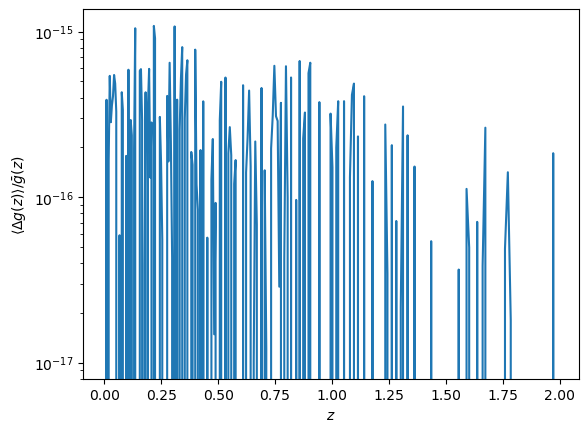

In [10]:
# Make sure that \delta g has no monopole
plt.semilogy(z_array[0,:], np.mean(delta_g_maps, axis=0)/g_fid)
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle \Delta g (z) \rangle / \bar{g}(z)$')

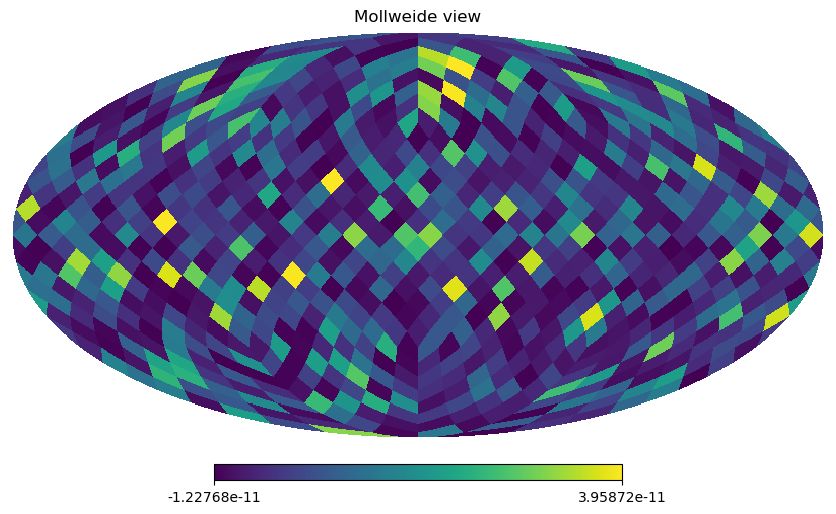

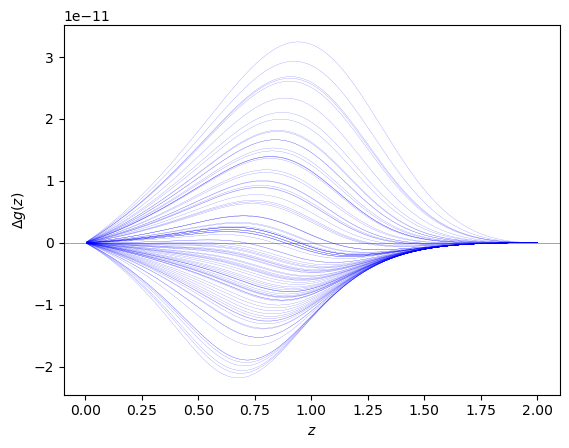

In [11]:
 # Plot a map of an chi-slice where we expect significant fluctuations
chi_mean_idx = np.where(chi_array>chi_mean_fid)[0][0]
hp.mollview(delta_g_maps[:,chi_mean_idx])
plt.show()

# Plot the Delta g (z) at a random pixel
plt.axhline(0, color='gray', lw=0.5)
for idx in np.random.randint(0, npix, size=100):
    plt.plot(z_array[idx,:], delta_g_maps[idx,:], color='b', lw=0.1)
plt.ylabel(r'$\Delta g(z)$')
plt.xlabel(r'$z$')
plt.show()

In [12]:
# Let us up-sample the maps
nside_out = 64 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

delta_g_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_chi))
for i in range(len(chi_array)):
    delta_g_maps_upsampled[:,i] = hp.ud_grade(delta_g_maps[:,i], nside_out)
    
delta_g_maps = delta_g_maps_upsampled

In [16]:
# To avoid ringing due to the hard edges on which we seed the anisotropy, we smooth the maps with a Gaussian 
# Actually, you probably don't wanna do this
smoothing_fraction = 0
sigma_gaussian_smoothing = smoothing_fraction * np.sqrt(4*np.pi/npix) * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

In [17]:
# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
delta_g_lm_of_chi = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_chi), dtype=complex)
for i in range(n_samples_of_chi):
    delta_g_lm_of_chi[:,i] = hp.map2alm(delta_g_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    delta_g_lm_of_chi[:,i] = hp.almxfl(delta_g_lm_of_chi[:,i], beam) 

In [18]:
lmax = hp.Alm.getlmax(delta_g_lm_of_chi.shape[0])
Cl_deltag_of_chi1_chi2 = np.zeros((lmax+1, n_samples_of_chi, n_samples_of_chi))
pixwinf = hp.pixwin(nside_out)[0:lmax+1] # Get the pixel window function for the up-sampled pixelization

for i in range(delta_g_lm_of_chi.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/delta_g_lm_of_chi.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m

    if m!=0:
        # Healpix indexes only m (not -m, since Ylm=Yl-m for a real field), so correct the sum for this
        factor = 2
    else:
        factor = 1

    # Get angular PS and deconvolve pixel window function for all possible combinations of chi1 and chi2 
    Cl_deltag_of_chi1_chi2[l,:,:] += factor*np.outer(delta_g_lm_of_chi[i,:], np.conj(delta_g_lm_of_chi[i,:])).real/ (2*l+1) / pixwinf[l]**2

Completed 0%
Completed 5%
Completed 11%
Completed 16%
Completed 22%
Completed 27%
Completed 32%
Completed 38%
Completed 43%
Completed 49%
Completed 54%
Completed 59%
Completed 65%
Completed 70%
Completed 76%
Completed 81%
Completed 86%
Completed 92%
Completed 97%


## Visualize $C_l^{\Delta g \Delta g}(\chi)$


(1.0, 5000.0)

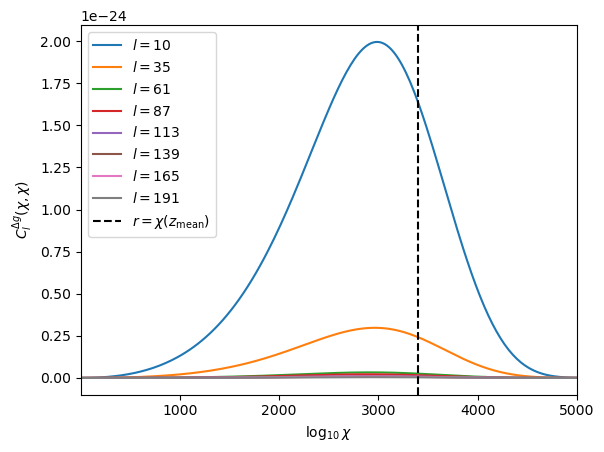

In [20]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.plot(chi_array, np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))

plt.axvline(chi_mean_fid, ls='--', color='k', label=r'$r=\chi(z_{\mathrm{mean}})$')
plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$C_l^{\Delta g}(\chi,\chi)$')
plt.legend()
plt.xlim([1,5000])

/tmp/ipykernel_49483/2667622951.py:9: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2))


(2.0, 241.0)

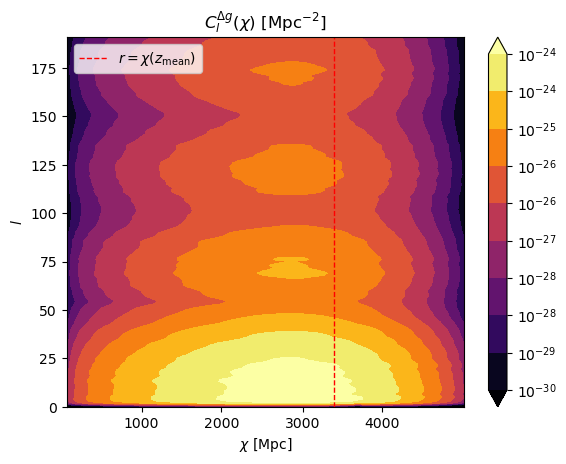

In [31]:
def find_closest_indices(chi_array, ref_array):
    overlapping = np.logical_and(ref_array > np.min(chi_array), ref_array < np.max(chi_array))
    out = np.zeros(np.sum(overlapping))
    for i, a in enumerate(ref_array[overlapping]):
        out[i] = np.abs(chi_array-a).argmin()
    return out.astype(int)

X, Y = np.meshgrid(np.arange(len(chi_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2))

contours = np.linspace(-30,-24,10)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=1)
plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='inferno', extend='both')


ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='r', ls='--', lw=1, label=r'$r=\chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'$l$')

label_locs = np.arange(1000,5000,1000, dtype=int)
ax.set_xticks(find_closest_indices(chi_array, label_locs))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$C_l^{\Delta g}(\chi)$ [Mpc$^{-2}$]')
cbar = plt.colorbar(location='right')
cbar.set_ticklabels(np.array([r'$10^{'+str(x)+'}$' for x in contours.astype(int)]))

plt.xlim([np.where(chi_array>50)[0][0], np.where(chi_array>5000)[0][0]])

## Visualize $C_l^{\Delta g \Delta g}(\chi_1,\chi_2)$



/tmp/ipykernel_49483/421014990.py:3: RuntimeWarning: divide by zero encountered in log10
  Z_fixed_chi = np.log10(np.abs(Cl_deltag_of_chi1_chi2[:,:,chi_idx]))


(2.0, 241.0)

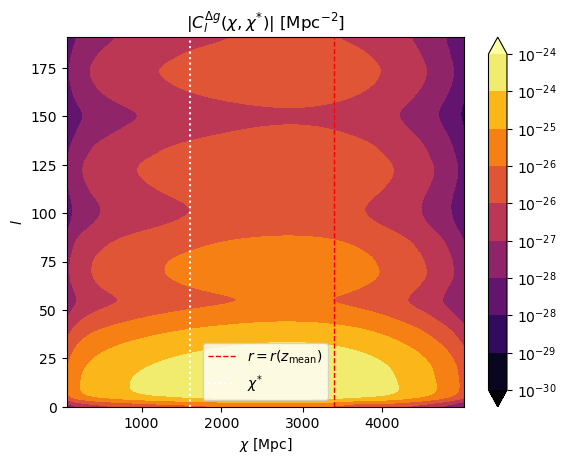

In [32]:
chi_idx = np.where(np.log10(chi_array)>3.2)[0][0]

Z_fixed_chi = np.log10(np.abs(Cl_deltag_of_chi1_chi2[:,:,chi_idx]))
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_chi_smoothed = gaussian_filter(Z_fixed_chi, sigma=3)

plt.contourf(X, Y, Z_fixed_chi_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='r', ls='--', lw=1, label=r'$r=r(z_{\mathrm{mean}})$')

ax.set_ylim([0,lmax])

label_locs = np.arange(1000,5000,1000, dtype=int)
ax.set_xticks(find_closest_indices(chi_array, label_locs))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$ |C_l^{\Delta g}(\chi,\chi^{*})|$ [Mpc$^{-2}$]')
cbar = plt.colorbar(location='right')
cbar.set_ticklabels(np.array([r'$10^{'+str(x)+'}$' for x in contours.astype(int)]))

ax.axvline(chi_idx, label=r'$\chi^{*}$', ls=':', color='w')
plt.legend()
plt.xlim([np.where(chi_array>50)[0][0], np.where(chi_array>5000)[0][0]])

# Non-linear matter PS

- Careful with factors of h!

Get the non-linear matter power spectrum at every z

Note: redshifts have been re-sorted (earliest first)


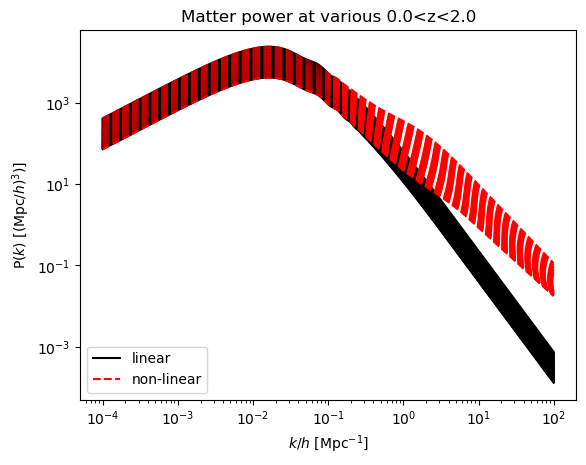

In [34]:
import camb
from camb import model

#Now get matter power spectra and sigma8 at redshifts between 0 and sufficiently behind the perturbed sources
pars = camb.CAMBparams()
h = Planck18.H0.value/100.
pars.set_cosmology(H0=Planck18.H0.value, ombh2=Planck18.Ob0 * h**2, omch2=Planck18.Odm0 * h**2)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
redshifts = np.linspace(0, z_mean+5*sigma_zshift)
pars.set_matter_power(redshifts=redshifts, kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1e2, npoints = 500)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1e2, npoints = 500)

for i, redshift in enumerate(np.array(z)):
    plt.loglog(kh, pk[i,:], color='k', ls = '-')
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = '--', label=redshift)
plt.xlabel(r'$k/h$ [Mpc$^{-1}$]');
plt.ylabel(r'P($k$) [(Mpc/$h)^3)$]');
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at various {}<z<{}'.format(np.min(z), np.max(z)));

# Remove factors of h
k_nonlin = kh_nonlin * h
pk_nonlin *= h**3

In [35]:
# Interpolate it
Pkmm_of_chi_interp = interpolate.RegularGridInterpolator((Planck18.comoving_distance(np.array(z)).value, k_nonlin), pk_nonlin,
                                   method='linear', bounds_error=True, fill_value=0)


# Calculate biases

#### In the Limber approximation

To DO:
- Allow Pkmm to vary with redshift? 
- Choose lprime_max more systematically
- Parallelize! (should be rather trivial to do)

In [76]:
g_fid_interp = interp1d(chi_array, g_fid)
g_pert_interp = interp1d(chi_array, g_pert)

Calculate the convolutional bias term

In [77]:
def integrand_conv_term(chi, small_l, big_L, prefactor):
    '''
    Integrand for the convolutional bias term in the Limber approximation.
    Requires globally-defined Pkmm_of_chi_interp(z, k) and cldp_interp(k)[l], interpolated in k
    '''
    return prefactor/ chi**2 * Pkmm_of_chi_interp(np.array((chi[0], (big_L+0.5)/chi[0])))[0] * cldg_interp(chi)[small_l]

# Interpolate the spectra to be integrated over
cldg_interp = interp1d(chi_array, np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2), axis=-1)
Pkmm_interp = interp1d(k_nonlin, pk_nonlin, bounds_error=False, fill_value='extrapolate')

lprime_max = 100 #Value of l above which we ignore the anisotropy in C_l^{\Delta \phi}(k)

conv_bias_ells = np.logspace(1.5, 3, 3, dtype=int)
conv_bias = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    for lprime in range(lprime_max):
        for L in np.arange(np.abs(l-lprime), np.abs(l+lprime)+1, 1):
            if (l+lprime+L)%2==0:
                w3 = wigner_3j(l, L, lprime, 0, 0, 0)
                prefactor = float(w3)**2 * (2*lprime+1) * (2*L+1) / (4*np.pi)
                integ, error = quadrature(integrand_conv_term,chi_min_int, chi_max_int, args=(lprime, L, prefactor), maxiter=1000, tol=1e-20)
                conv_bias[i] += integ

Working on l=31; iteration 1/3
Working on l=177; iteration 2/3
Working on l=1000; iteration 3/3


Get the unbiased Clkk for comparison -- for now, only auto of a given bin

In [78]:
def integrand_unbiased_auto_term(chi, small_l):
    '''
    Integrand for the unbiased Clkk auto spectrum in the Limber approximation.
    Requires globally-defined Pkmm_of_chi_interp(z, k), interpolated in k and assumed to be z-idependent
    '''
    return Pkmm_of_chi_interp(np.array((chi[0], (small_l+0.5)/chi[0])))[0] * (g_fid_interp(chi)/chi)**2

clkk_unbiased = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    clkk_unbiased[i], error = quadrature(integrand_unbiased_auto_term, chi_min_int, 
                                       chi_max_int, args=(l), maxiter=2000, tol=1e-20)

Working on l=31; iteration 1/3
Working on l=177; iteration 2/3
Working on l=1000; iteration 3/3


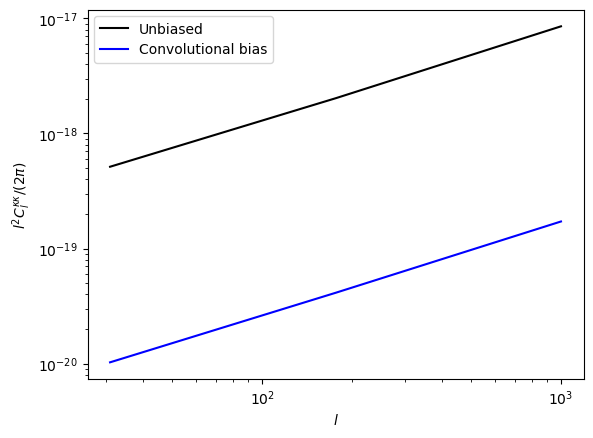

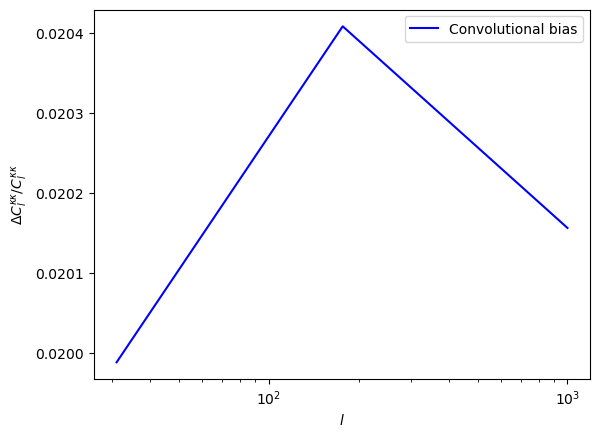

In [79]:
scaling = conv_bias_ells**2/(2*np.pi)
plt.loglog(conv_bias_ells, scaling * clkk_unbiased, 'k', label=r'Unbiased')
plt.loglog(conv_bias_ells, scaling * conv_bias, 'b', label=r'Convolutional bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$l^2 C_l^{\kappa\kappa} / (2\pi)$')
plt.legend()

plt.show()

plt.plot(conv_bias_ells, conv_bias/clkk_unbiased, 'b', label=r'Convolutional bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$\Delta C_l^{\kappa\kappa} / C_l^{\kappa\kappa}$')
plt.legend()

plt.xscale('log')